<a href="https://colab.research.google.com/github/lokeshpara/Deeplearning/blob/S10/EVA_session10_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/EVA/S10/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/EVA/S10


#Importing modules


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import numpy as np
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensor
import random
from GradCAM.gradcam_visualize import GradCAMView
import dataloader10
import resnet
import train10
import test10
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


  pip install torch-lr-finder -v --global-option="amp"


#Visualize images

  dog horse   cat   cat


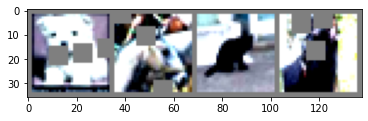

In [50]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloader10.train_loader_Alb)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#ResNet Total parameters

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

#LR_Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



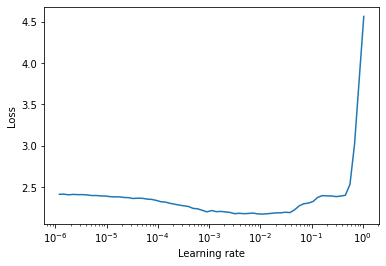

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters() , lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader10.train_loader, end_lr=100, num_iter=100, step_mode="exp")                                
lr_finder.plot() 
#lr_finder.reset()                                                                                                                                              

In [0]:
Best_lr=lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]

In [0]:
lr_finder.reset()

In [28]:
print("lr:" , Best_lr)
print('Loss:', lr_finder.best_loss)

lr: 0.010964781961431861
Loss: 2.171982282194678


In [29]:
model =  resnet.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), Best_lr , momentum=0.9, weight_decay=0) 
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
loss_func=nn.CrossEntropyLoss()

for epoch in range(50):
    print("Epoch:", epoch)
    train10.train(model, device, dataloader10.train_loader_Albumentation, optimizer, loss_func, epoch)
    # scheduler.step()
    test10.test(model, device, dataloader10.test_loader, loss_func, last_epoch=True)
    scheduler.step(test10.test_losses[-1])

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0


Epoch= 0 Loss=1.1422195434570312 Batch_id=781 Accuracy=38.39: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 4890/10000 (48.90%)

Epoch: 1


Epoch= 1 Loss=0.6745113134384155 Batch_id=781 Accuracy=53.64: 100%|██████████| 782/782 [00:33<00:00, 23.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 5801/10000 (58.01%)

Epoch: 2


Epoch= 2 Loss=1.2500426769256592 Batch_id=781 Accuracy=61.52: 100%|██████████| 782/782 [00:32<00:00, 23.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 6903/10000 (69.03%)

Epoch: 3


Epoch= 3 Loss=1.1653485298156738 Batch_id=781 Accuracy=66.38: 100%|██████████| 782/782 [00:33<00:00, 23.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 7529/10000 (75.29%)

Epoch: 4


Epoch= 4 Loss=0.9644535779953003 Batch_id=781 Accuracy=69.91: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 7646/10000 (76.46%)

Epoch: 5


Epoch= 5 Loss=0.8524024486541748 Batch_id=781 Accuracy=72.32: 100%|██████████| 782/782 [00:32<00:00, 24.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 7937/10000 (79.37%)

Epoch: 6


Epoch= 6 Loss=0.6139087677001953 Batch_id=781 Accuracy=74.49: 100%|██████████| 782/782 [00:32<00:00, 23.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 7986/10000 (79.86%)

Epoch: 7


Epoch= 7 Loss=0.8817408680915833 Batch_id=781 Accuracy=76.07: 100%|██████████| 782/782 [00:32<00:00, 24.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 8053/10000 (80.53%)

Epoch: 8


Epoch= 8 Loss=0.5671722888946533 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [00:32<00:00, 24.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8183/10000 (81.83%)

Epoch: 9


Epoch= 9 Loss=0.6111767888069153 Batch_id=781 Accuracy=78.48: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 8105/10000 (81.05%)

Epoch: 10


Epoch= 10 Loss=0.6988748908042908 Batch_id=781 Accuracy=80.04: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8169/10000 (81.69%)

Epoch: 11


Epoch= 11 Loss=0.5605396032333374 Batch_id=781 Accuracy=80.84: 100%|██████████| 782/782 [00:32<00:00, 24.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8318/10000 (83.18%)

Epoch: 12


Epoch= 12 Loss=0.17659083008766174 Batch_id=781 Accuracy=81.60: 100%|██████████| 782/782 [00:32<00:00, 24.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8350/10000 (83.50%)

Epoch: 13


Epoch= 13 Loss=0.4487900733947754 Batch_id=781 Accuracy=82.51: 100%|██████████| 782/782 [00:32<00:00, 24.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8484/10000 (84.84%)

Epoch: 14


Epoch= 14 Loss=0.37940138578414917 Batch_id=781 Accuracy=83.16: 100%|██████████| 782/782 [00:32<00:00, 24.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8419/10000 (84.19%)

Epoch: 15


Epoch= 15 Loss=0.2507258951663971 Batch_id=781 Accuracy=83.73: 100%|██████████| 782/782 [00:32<00:00, 23.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8460/10000 (84.60%)

Epoch: 16


Epoch= 16 Loss=0.8048114776611328 Batch_id=781 Accuracy=84.39: 100%|██████████| 782/782 [00:32<00:00, 24.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8727/10000 (87.27%)

Epoch: 17


Epoch= 17 Loss=0.4567977488040924 Batch_id=781 Accuracy=84.92: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8655/10000 (86.55%)

Epoch: 18


Epoch= 18 Loss=0.9848877191543579 Batch_id=781 Accuracy=85.52: 100%|██████████| 782/782 [00:32<00:00, 24.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8629/10000 (86.29%)

Epoch: 19


Epoch= 19 Loss=0.3163833022117615 Batch_id=781 Accuracy=85.99: 100%|██████████| 782/782 [00:32<00:00, 24.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8633/10000 (86.33%)

Epoch: 20


Epoch= 20 Loss=0.6978759765625 Batch_id=781 Accuracy=86.46: 100%|██████████| 782/782 [00:32<00:00, 23.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8662/10000 (86.62%)

Epoch: 21


Epoch= 21 Loss=0.38183724880218506 Batch_id=781 Accuracy=89.41: 100%|██████████| 782/782 [00:32<00:00, 23.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8986/10000 (89.86%)

Epoch: 22


Epoch= 22 Loss=0.17558540403842926 Batch_id=781 Accuracy=90.23: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8959/10000 (89.59%)

Epoch: 23


Epoch= 23 Loss=0.8998523354530334 Batch_id=781 Accuracy=90.59: 100%|██████████| 782/782 [00:33<00:00, 23.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8989/10000 (89.89%)

Epoch: 24


Epoch= 24 Loss=0.46632906794548035 Batch_id=781 Accuracy=90.77: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9004/10000 (90.04%)

Epoch: 25


Epoch= 25 Loss=0.14886713027954102 Batch_id=781 Accuracy=91.04: 100%|██████████| 782/782 [00:32<00:00, 23.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9011/10000 (90.11%)

Epoch: 26


Epoch= 26 Loss=0.17022672295570374 Batch_id=781 Accuracy=91.20: 100%|██████████| 782/782 [00:32<00:00, 23.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9027/10000 (90.27%)

Epoch: 27


Epoch= 27 Loss=0.09700614213943481 Batch_id=781 Accuracy=91.38: 100%|██████████| 782/782 [00:32<00:00, 23.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 9004/10000 (90.04%)

Epoch: 28


Epoch= 28 Loss=0.20232322812080383 Batch_id=781 Accuracy=91.69: 100%|██████████| 782/782 [00:32<00:00, 23.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9035/10000 (90.35%)

Epoch: 29


Epoch= 29 Loss=0.05936330556869507 Batch_id=781 Accuracy=91.86: 100%|██████████| 782/782 [00:32<00:00, 23.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9029/10000 (90.29%)

Epoch: 30


Epoch= 30 Loss=0.29204508662223816 Batch_id=781 Accuracy=91.96: 100%|██████████| 782/782 [00:33<00:00, 23.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9045/10000 (90.45%)

Epoch: 31


Epoch= 31 Loss=0.17982599139213562 Batch_id=781 Accuracy=91.99: 100%|██████████| 782/782 [00:33<00:00, 23.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9055/10000 (90.55%)

Epoch: 32


Epoch= 32 Loss=0.11792120337486267 Batch_id=781 Accuracy=92.34: 100%|██████████| 782/782 [00:32<00:00, 23.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9053/10000 (90.53%)

Epoch: 33


Epoch= 33 Loss=0.42688751220703125 Batch_id=781 Accuracy=92.01: 100%|██████████| 782/782 [00:32<00:00, 24.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9039/10000 (90.39%)

Epoch: 34


Epoch= 34 Loss=0.07642842829227448 Batch_id=781 Accuracy=92.18: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9050/10000 (90.50%)

Epoch: 35


Epoch= 35 Loss=0.1426667869091034 Batch_id=781 Accuracy=92.30: 100%|██████████| 782/782 [00:32<00:00, 24.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9053/10000 (90.53%)

Epoch: 36


Epoch= 36 Loss=0.2968495190143585 Batch_id=781 Accuracy=92.14: 100%|██████████| 782/782 [00:32<00:00, 24.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9051/10000 (90.51%)

Epoch: 37


Epoch= 37 Loss=0.4331679344177246 Batch_id=781 Accuracy=92.04: 100%|██████████| 782/782 [00:32<00:00, 23.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9064/10000 (90.64%)

Epoch: 38


Epoch= 38 Loss=0.927838921546936 Batch_id=781 Accuracy=92.27: 100%|██████████| 782/782 [00:33<00:00, 23.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9052/10000 (90.52%)

Epoch: 39


Epoch= 39 Loss=0.2356540858745575 Batch_id=781 Accuracy=92.41: 100%|██████████| 782/782 [00:33<00:00, 23.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9064/10000 (90.64%)

Epoch: 40


Epoch= 40 Loss=0.21610300242900848 Batch_id=781 Accuracy=92.15: 100%|██████████| 782/782 [00:33<00:00, 23.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9044/10000 (90.44%)

Epoch: 41


Epoch= 41 Loss=0.2099096179008484 Batch_id=781 Accuracy=92.22: 100%|██████████| 782/782 [00:32<00:00, 23.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9052/10000 (90.52%)

Epoch: 42


Epoch= 42 Loss=0.408166766166687 Batch_id=781 Accuracy=92.16: 100%|██████████| 782/782 [00:32<00:00, 24.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9044/10000 (90.44%)

Epoch: 43


Epoch= 43 Loss=0.5244457721710205 Batch_id=781 Accuracy=92.30: 100%|██████████| 782/782 [00:32<00:00, 23.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9057/10000 (90.57%)

Epoch: 44


Epoch= 44 Loss=0.3741295635700226 Batch_id=781 Accuracy=92.21: 100%|██████████| 782/782 [00:32<00:00, 24.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9063/10000 (90.63%)

Epoch: 45


Epoch= 45 Loss=0.033023953437805176 Batch_id=781 Accuracy=92.10: 100%|██████████| 782/782 [00:32<00:00, 24.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9061/10000 (90.61%)

Epoch: 46


Epoch= 46 Loss=0.2434798628091812 Batch_id=781 Accuracy=92.41: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9056/10000 (90.56%)

Epoch: 47


Epoch= 47 Loss=0.3734480142593384 Batch_id=781 Accuracy=92.20: 100%|██████████| 782/782 [00:32<00:00, 23.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9063/10000 (90.63%)

Epoch: 48


Epoch= 48 Loss=0.2766651213169098 Batch_id=781 Accuracy=92.40: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9062/10000 (90.62%)

Epoch: 49


Epoch= 49 Loss=0.27390652894973755 Batch_id=781 Accuracy=92.45: 100%|██████████| 782/782 [00:32<00:00, 23.98it/s]



Test set: Average loss: 0.0046, Accuracy: 9071/10000 (90.71%)



GroundTruth:  horse   dog   car  deer


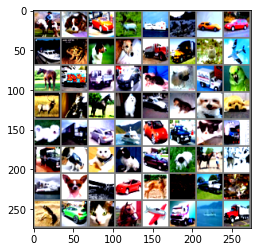

In [30]:
dataiter = iter(dataloader10.test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  horse   dog   car  deer


#Test_class_performs

In [34]:
from tqdm import tqdm

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  pbar = tqdm(dataloader10.test_loader)
  for i, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == target).squeeze()
    for i in range(4):
        label = target[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

100%|██████████| 157/157 [00:02<00:00, 54.77it/s]

Accuracy of plane : 91 %
Accuracy of   car : 95 %
Accuracy of  bird : 87 %
Accuracy of   cat : 82 %
Accuracy of  deer : 92 %
Accuracy of   dog : 82 %
Accuracy of  frog : 95 %
Accuracy of horse : 100 %
Accuracy of  ship : 98 %
Accuracy of truck : 88 %


#train_&_test_accuracy

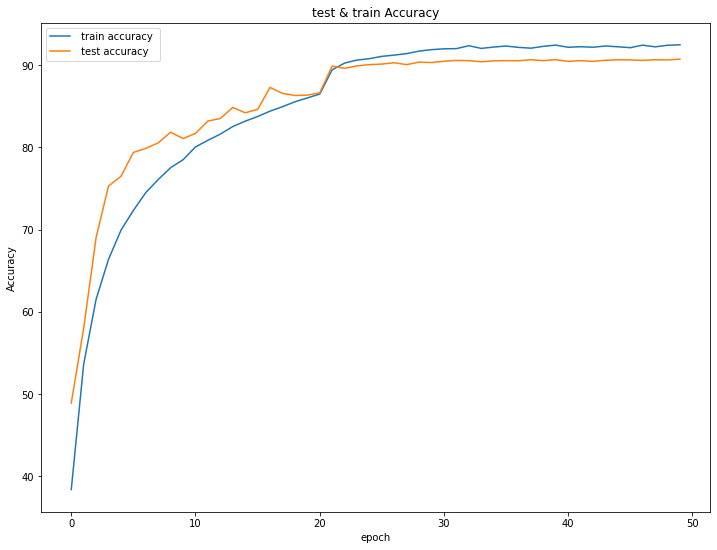

In [35]:
fig, axs = plt.subplots(1,1,figsize=(12,9))
plt.plot(train10.train_acc)
plt.plot(test10.test_acc)

plt.title('test & train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend([" train accuracy ", ' test accuracy '], loc='best')
plt.show()

#GradCAM for 25 misclassified images

/content/gdrive/My Drive/Colab Notebooks/EVA/S10/GradCAM/gradcam_visualize.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw={'xticks': [], 'yticks': []})


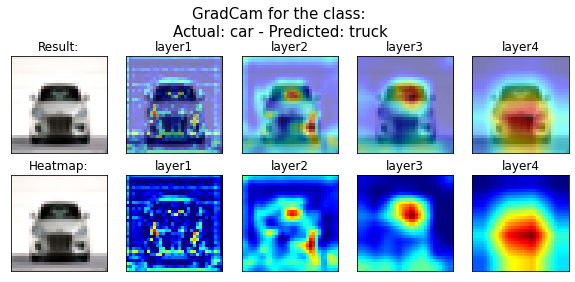

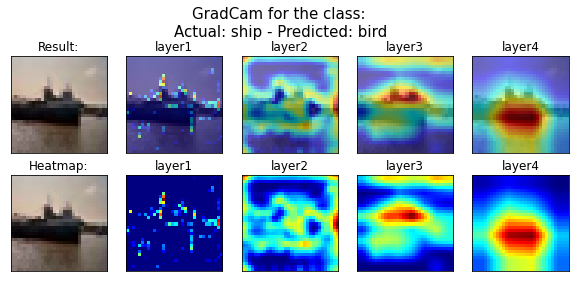

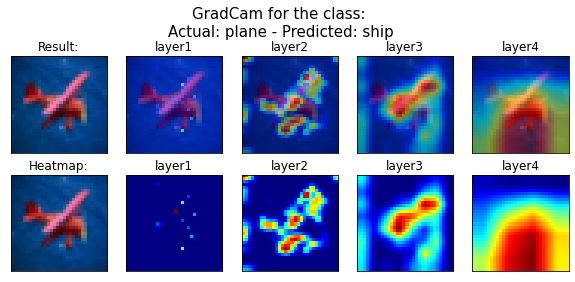

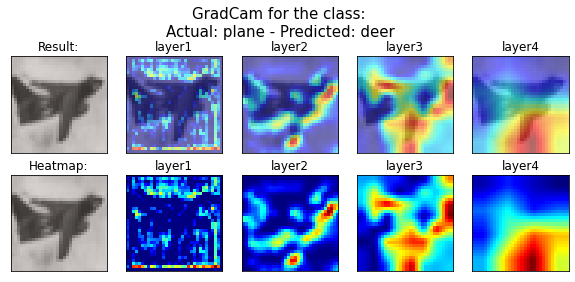

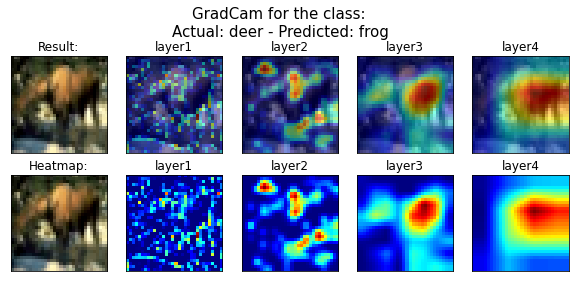

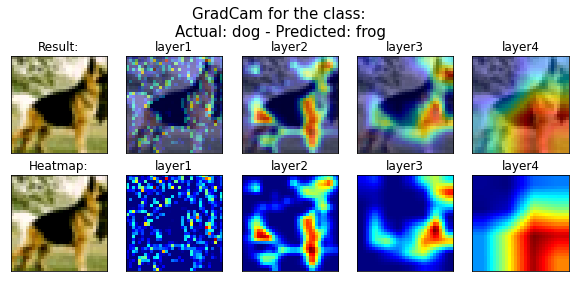

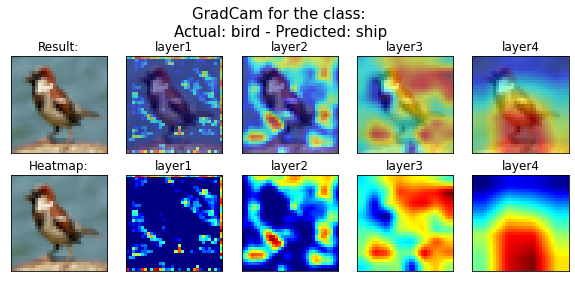

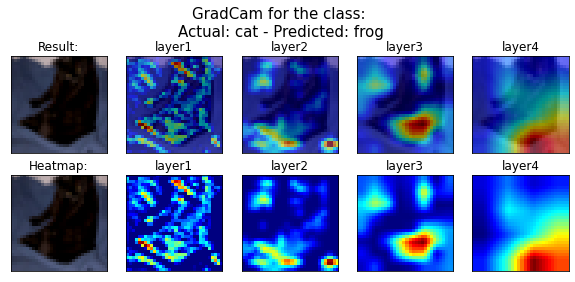

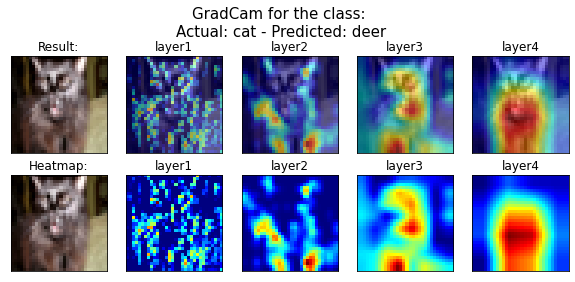

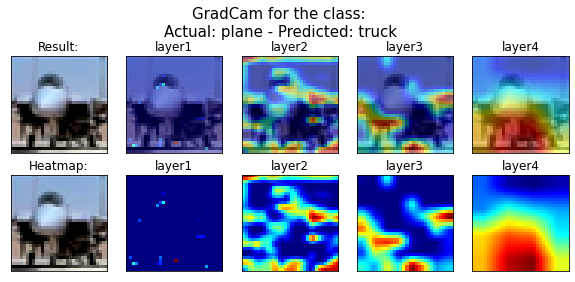

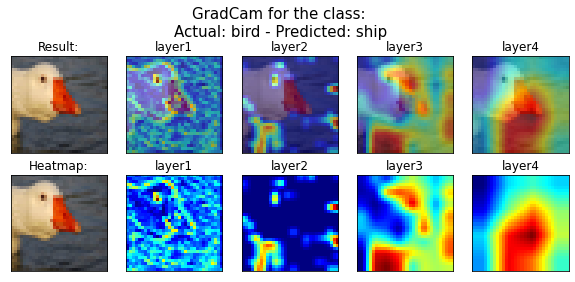

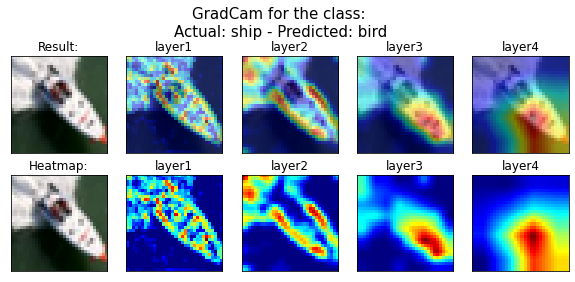

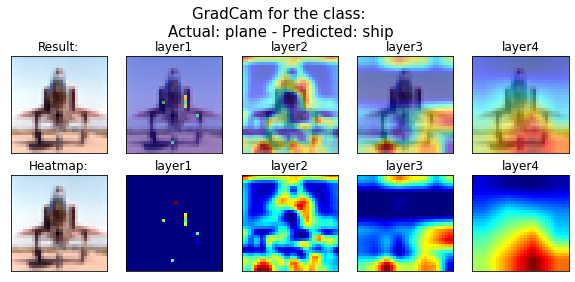

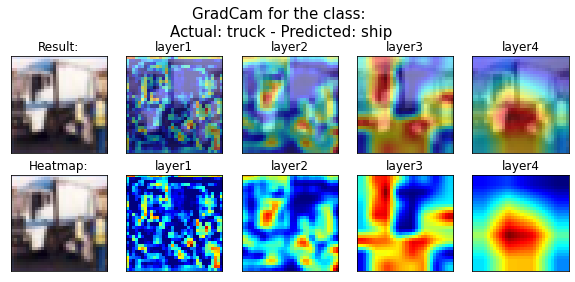

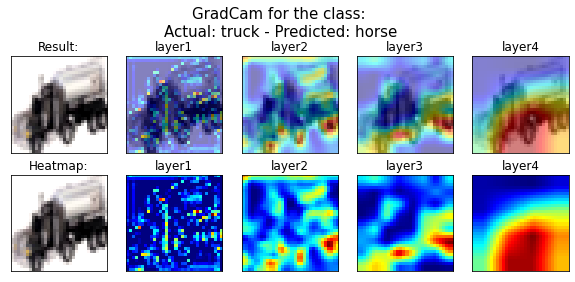

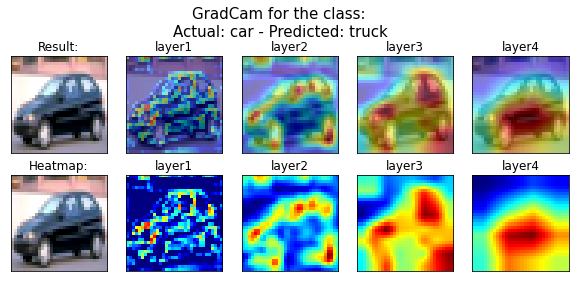

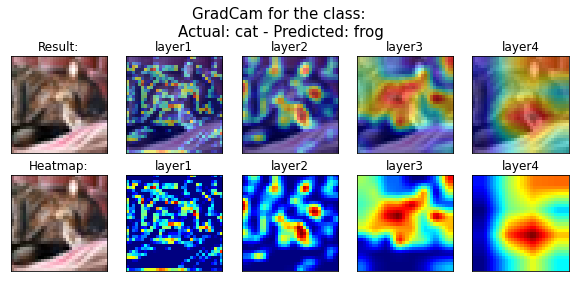

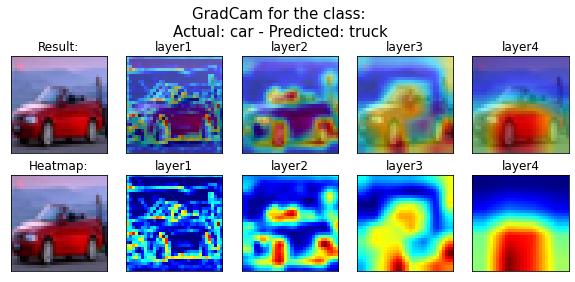

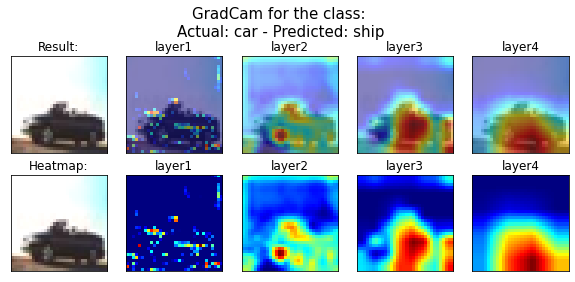

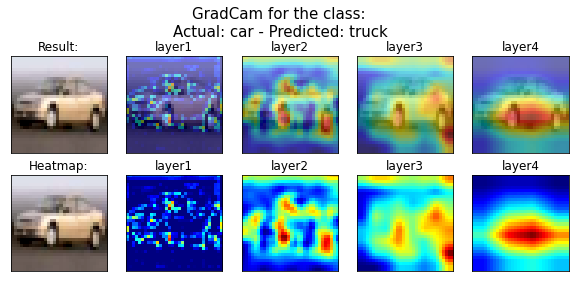

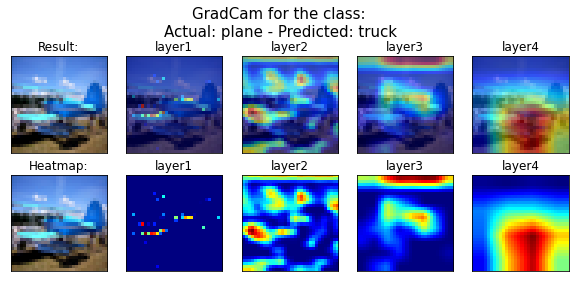

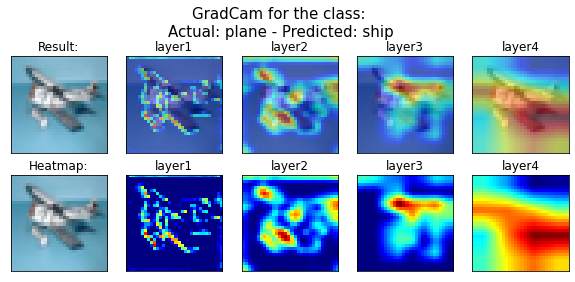

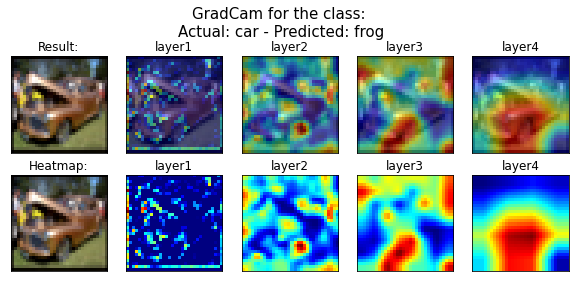

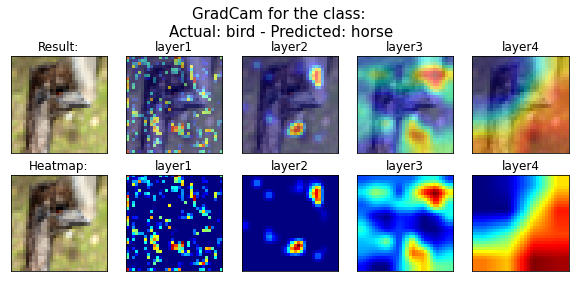

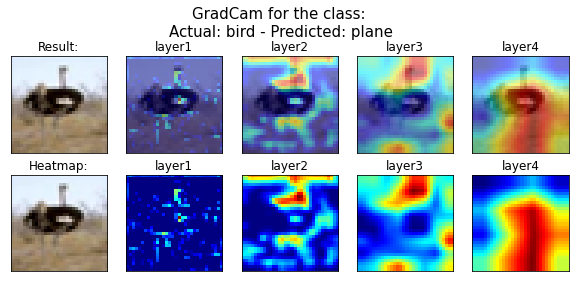

In [36]:
num_img = 25
incorrect_pred_imgs = []
truth_image = []
target_layers = ["layer1","layer2","layer3","layer4"]  
grad_cam = GradCAMView(model ,classes,target_layers )  
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(test10.misclassified[i]["image"]))
  truth_image.append(test10.misclassified[i]["prediction"])
grad_cam(torch.stack(incorrect_pred_imgs), truth_image, target_layers, metric="incorrect",per_image=True)